<a href="https://colab.research.google.com/github/6Fun6Maker6/-/blob/main/%D0%94%D0%BE%D0%B1%D1%80%D0%BE_%D0%BF%D0%BE%D0%B6%D0%B0%D0%BB%D0%BE%D0%B2%D0%B0%D1%82%D1%8C_%D0%B2_Colab!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

from google.colab import files
import pandas as pd
import io

# Загружаем файл с компьютера
uploaded = files.upload()

# Получаем имя загруженного файла
filename = list(uploaded.keys())[0]
print(f"Загружен файл: {filename}")

# Чтение данных
df = pd.read_csv(io.BytesIO(uploaded[filename]), parse_dates=['Дата'], dayfirst=True)
df = df.sort_values('Дата').reset_index(drop=True)
df.columns = ['date', 'services']

print("Первые 5 строк данных:")
print(df.head())
print(f"\nВсего записей: {len(df)}")
print(f"Период данных: с {df['date'].min()} по {df['date'].max()}")

Saving брони.csv to брони (3).csv
Загружен файл: брони (3).csv
Первые 5 строк данных:
         date  services
0  2025-01-02         2
1  2025-01-03        10
2  2025-01-04        16
3  2025-01-05        26
4  2025-01-06         6

Всего записей: 295
Период данных: с 2025-01-02 по 2025-10-31


Примеры дат в данных:
0    2025-01-02
1    2025-01-03
2    2025-01-04
3    2025-01-05
4    2025-01-06
5    2025-01-07
6    2025-01-08
7    2025-01-09
8    2025-01-10
9    2025-01-11
Name: date, dtype: object

Тип данных столбца date: object
✓ Успешно преобразовано с format='mixed'

После преобразования:
Тип данных столбца date: datetime64[ns]
Пропущенных дат: 0
Примеры преобразованных дат:
0   2025-01-02
1   2025-01-03
2   2025-01-04
3   2025-01-05
4   2025-01-06
Name: date, dtype: datetime64[ns]

Продолжаем с 295 корректными записями
Всего дней в периоде: 303
Дней с данными: 295
Пропущенных дней: 8

Дней когда спа не работал: 8


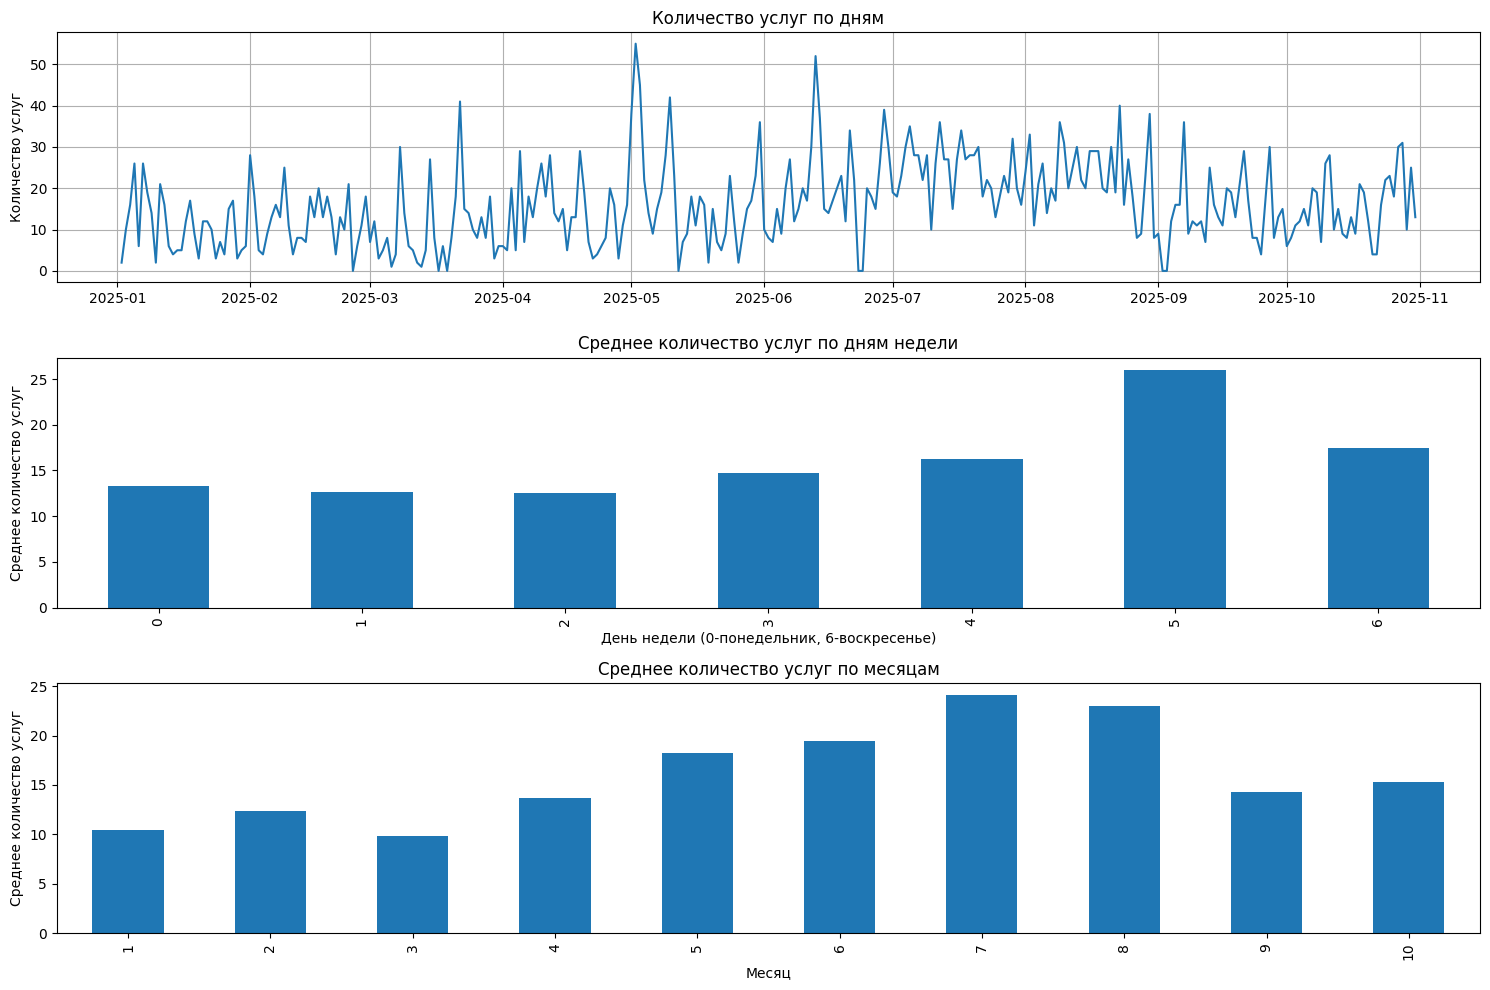


Дополнительная информация:
Общий период: с 2025-01-02 по 2025-10-31
Всего дней в датасете: 303
Среднее количество услуг в день: 16.12
Максимальное количество услуг: 55.0
Минимальное количество услуг: 0.0


In [26]:
# Сначала посмотрим на реальные данные в столбце date
print("Примеры дат в данных:")
print(df['date'].head(10))
print(f"\nТип данных столбца date: {df['date'].dtype}")

# Попробуем разные способы преобразования дат
try:
    # Способ 1: Пробуем автоматическое определение формата
    df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)
    print("✓ Успешно преобразовано с format='mixed'")

except Exception as e:
    print(f"Способ 1 не сработал: {e}")

    try:
        # Способ 2: Пробуем infer_datetime_format
        df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True, dayfirst=True)
        print("✓ Успешно преобразовано с infer_datetime_format=True")

    except Exception as e:
        print(f"Способ 2 не сработал: {e}")

        try:
            # Способ 3: Пробуем разные форматы вручную
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            # Проверим, есть ли пропуски после преобразования
            nan_count = df['date'].isna().sum()
            if nan_count > 0:
                print(f"⚠ Не удалось преобразовать {nan_count} дат")
                # Покажем проблемные строки
                problematic_dates = df[df['date'].isna()]
                print("Проблемные строки:")
                print(problematic_dates.head())
            print("✓ Успешно преобразовано с errors='coerce'")

        except Exception as e:
            print(f"Способ 3 не сработал: {e}")

            # Способ 4: Очистка данных и повторная попытка
            print("Пробуем очистить данные...")
            # Удаляем лишние символы и пробелы
            df['date'] = df['date'].astype(str).str.strip()
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            print("✓ Преобразовано после очистки")

# Проверим результат преобразования
print(f"\nПосле преобразования:")
print(f"Тип данных столбца date: {df['date'].dtype}")
print(f"Пропущенных дат: {df['date'].isna().sum()}")
print(f"Примеры преобразованных дат:")
print(df['date'].head())

# Удалим строки с некорректными датами, если они есть
if df['date'].isna().any():
    print(f"\nУдаляем {df['date'].isna().sum()} строк с некорректными датами")
    df = df.dropna(subset=['date']).reset_index(drop=True)

# Теперь продолжаем с остальным кодом
print(f"\nПродолжаем с {len(df)} корректными записями")

# Проверим пропущенные даты
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
print(f"Всего дней в периоде: {len(date_range)}")
print(f"Дней с данными: {len(df)}")
print(f"Пропущенных дней: {len(date_range) - len(df)}")

# Заполним пропуски (дни когда спа не работал) нулями или интерполяцией
df_full = pd.DataFrame({'date': date_range})
df_full = df_full.merge(df, on='date', how='left')

# Отметим дни когда спа не работал (значение NaN)
non_working_days = df_full[df_full['services'].isna()]
print(f"\nДней когда спа не работал: {len(non_working_days)}")

# Заполним пропуски - можно разными способами
# Способ 1: нулями
df_full['services'] = df_full['services'].fillna(0)

# Создаем дополнительные признаки
df_full['day_of_week'] = df_full['date'].dt.dayofweek
df_full['month'] = df_full['date'].dt.month
df_full['is_weekend'] = (df_full['date'].dt.dayofweek >= 5).astype(int)
df_full['day_of_month'] = df_full['date'].dt.day

# Визуализация данных
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df_full['date'], df_full['services'])
plt.title('Количество услуг по дням')
plt.ylabel('Количество услуг')
plt.grid(True)

plt.subplot(3, 1, 2)
df_full.groupby('day_of_week')['services'].mean().plot(kind='bar')
plt.title('Среднее количество услуг по дням недели')
plt.xlabel('День недели (0-понедельник, 6-воскресенье)')
plt.ylabel('Среднее количество услуг')

plt.subplot(3, 1, 3)
df_full.groupby('month')['services'].mean().plot(kind='bar')
plt.title('Среднее количество услуг по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество услуг')

plt.tight_layout()
plt.show()

# Дополнительная информация о данных
print(f"\nДополнительная информация:")
print(f"Общий период: с {df_full['date'].min().strftime('%Y-%m-%d')} по {df_full['date'].max().strftime('%Y-%m-%d')}")
print(f"Всего дней в датасете: {len(df_full)}")
print(f"Среднее количество услуг в день: {df_full['services'].mean():.2f}")
print(f"Максимальное количество услуг: {df_full['services'].max()}")
print(f"Минимальное количество услуг: {df_full['services'].min()}")

In [27]:
# Нормализация данных
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_full[['services']])

# Создание последовательностей для обучения
def create_sequences(data, sequence_length=30):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

SEQUENCE_LENGTH = 30  # смотрим на 30 дней чтобы предсказать следующий
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

# Разделение на обучающую и тестовую выборки
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (218, 30, 1)
Размер тестовой выборки: (55, 30, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0707 - mae: 0.2113 - val_loss: 0.0329 - val_mae: 0.1584
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0420 - mae: 0.1697 - val_loss: 0.0202 - val_mae: 0.1171
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0321 - mae: 0.1377 - val_loss: 0.0212 - val_mae: 0.1147
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0297 - mae: 0.1296 - val_loss: 0.0220 - val_mae: 0.1280
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0346 - mae: 0.1463 - val_loss: 0.0206 - val_mae: 0.1212
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0302 - mae: 0.1378 - val_loss: 0.0202 - val_mae: 0.1179
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0304 - mae: 0.1347 - val_loss: 0.0205 - val_mae: 0.1202
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0314 - mae: 0.1403 - val_loss: 0.0206 - val_mae: 0.1205
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0313 -

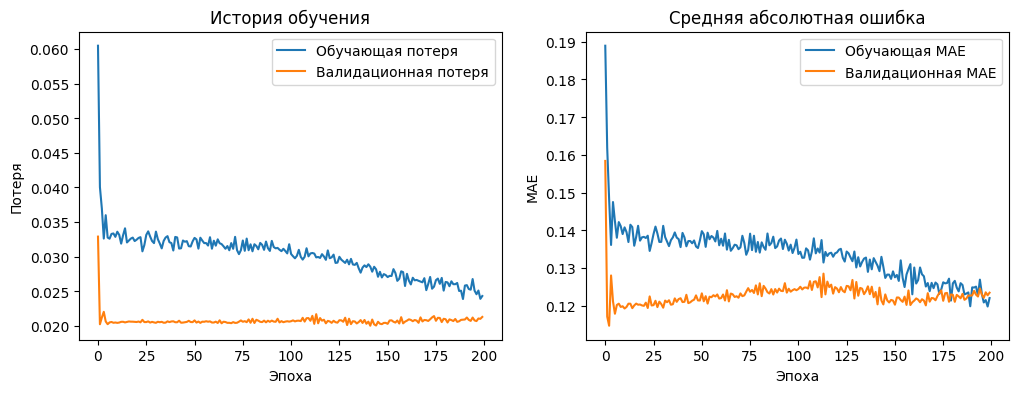

In [28]:
# Создание модели LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQUENCE_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

print(model.summary())

# Обучение модели
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False
)

# График обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучающая потеря')
plt.plot(history.history['val_loss'], label='Валидационная потеря')
plt.title('История обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Обучающая MAE')
plt.plot(history.history['val_mae'], label='Валидационная MAE')
plt.title('Средняя абсолютная ошибка')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
Средняя абсолютная ошибка (MAE): 6.79
Средняя абсолютная процентная ошибка (MAPE): 61.25%


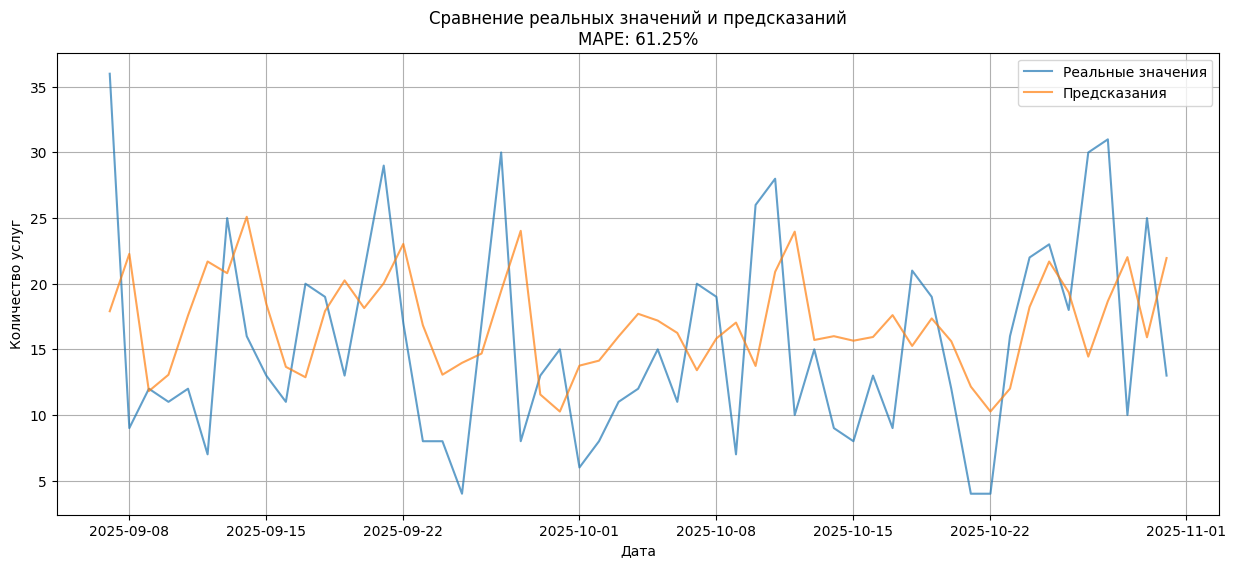

In [29]:
# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Обратное преобразование к исходному масштабу
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)

# Расчет метрик
mae = mean_absolute_error(y_test_original, y_pred_original)
mape = mean_absolute_percentage_error(y_test_original, y_pred_original) * 100

print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Средняя абсолютная процентная ошибка (MAPE): {mape:.2f}%")

# Визуализация предсказаний
test_dates = df_full['date'].iloc[train_size + SEQUENCE_LENGTH:train_size + SEQUENCE_LENGTH + len(y_test)]

plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_original, label='Реальные значения', alpha=0.7)
plt.plot(test_dates, y_pred_original, label='Предсказания', alpha=0.7)
plt.title(f'Сравнение реальных значений и предсказаний\nMAPE: {mape:.2f}%')
plt.xlabel('Дата')
plt.ylabel('Количество услуг')
plt.legend()
plt.grid(True)
plt.show()

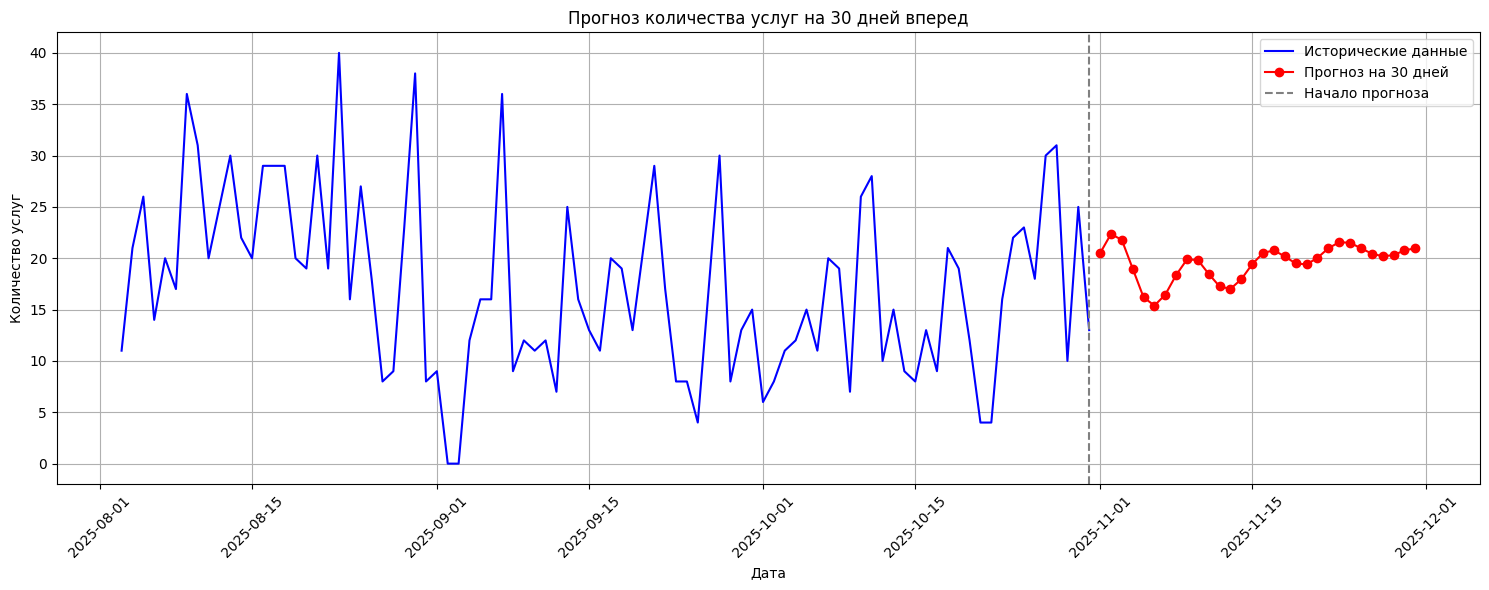

Прогноз на 30 дней вперед:
      Дата  Прогноз_услуг
2025-11-01           20.0
2025-11-02           22.0
2025-11-03           22.0
2025-11-04           19.0
2025-11-05           16.0
2025-11-06           15.0
2025-11-07           16.0
2025-11-08           18.0
2025-11-09           20.0
2025-11-10           20.0
2025-11-11           18.0
2025-11-12           17.0
2025-11-13           17.0
2025-11-14           18.0
2025-11-15           19.0
2025-11-16           21.0
2025-11-17           21.0
2025-11-18           20.0
2025-11-19           19.0
2025-11-20           19.0
2025-11-21           20.0
2025-11-22           21.0
2025-11-23           22.0
2025-11-24           22.0
2025-11-25           21.0
2025-11-26           20.0
2025-11-27           20.0
2025-11-28           20.0
2025-11-29           21.0
2025-11-30           21.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
def predict_future(model, last_sequence, days=30):
    """Прогноз на будущие дни"""
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days):
        # Предсказание следующего значения
        next_pred = model.predict(current_sequence.reshape(1, SEQUENCE_LENGTH, 1), verbose=0)
        future_predictions.append(next_pred[0, 0])

        # Обновление последовательности
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]

    return np.array(future_predictions)

# Берем последнюю последовательность из данных
last_sequence = scaled_data[-SEQUENCE_LENGTH:]

# Прогноз на 30 дней
future_predictions_scaled = predict_future(model, last_sequence, days=30)
future_predictions = scaler.inverse_transform(future_predictions_scaled.reshape(-1, 1))

# Создаем даты для прогноза
last_date = df_full['date'].iloc[-1]
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 31)]

# Визуализация прогноза
plt.figure(figsize=(15, 6))

# Исторические данные (последние 90 дней)
historical_dates = df_full['date'].iloc[-90:]
historical_services = df_full['services'].iloc[-90:]

plt.plot(historical_dates, historical_services, label='Исторические данные', color='blue')
plt.plot(future_dates, future_predictions, label='Прогноз на 30 дней', color='red', marker='o')
plt.axvline(x=last_date, color='gray', linestyle='--', label='Начало прогноза')

plt.title('Прогноз количества услуг на 30 дней вперед')
plt.xlabel('Дата')
plt.ylabel('Количество услуг')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Вывод прогноза в таблицу
forecast_df = pd.DataFrame({
    'Дата': future_dates,
    'Прогноз_услуг': future_predictions.flatten().round()
})

print("Прогноз на 30 дней вперед:")
print(forecast_df.to_string(index=False))

# Сохранение прогноза
forecast_df.to_csv('spa_forecast_next_30_days.csv', index=False)
files.download('spa_forecast_next_30_days.csv')